Classificateurs par vote

In [43]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=10000, noise=0.25, random_state=42)
X_train, X_test, y_train, y_test = X[:6000], X[6000:], y[:6000], y[6000:]

In [44]:
import numpy as np 
shuffle_index = np.random.permutation(6000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC(probability=True)
voting_clf = VotingClassifier(
        estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
        voting='soft'
    )
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()),
                             ('svc', SVC(probability=True))],
                 voting='soft')

In [46]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.86925
RandomForestClassifier 0.9425
SVC 0.944
VotingClassifier 0.947


Bagging et Pasting

In [47]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
        DecisionTreeClassifier(), n_estimators=500,
        max_samples=100, bootstrap=True, n_jobs=-1 # n_jobs=-1 signifie qu'on utilise tous les coeurs
    )
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

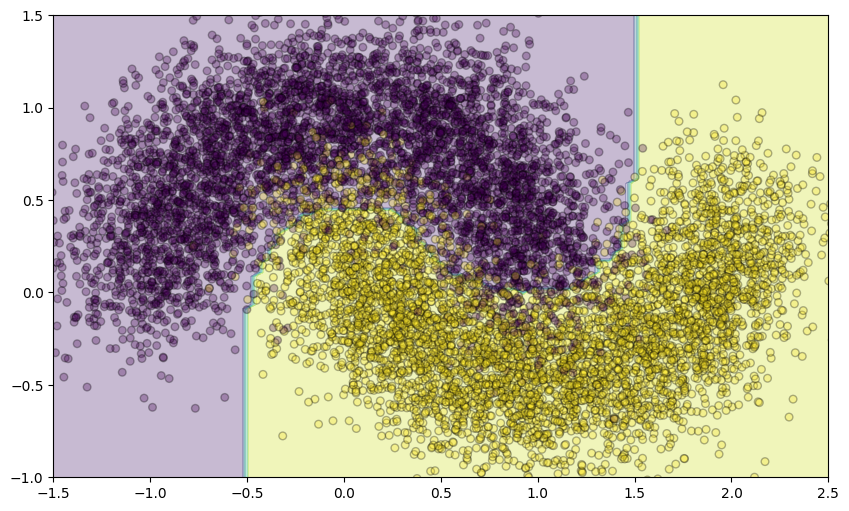

In [48]:
import matplotlib.pyplot as plt

def plot_decision_boundary(clf, X, y, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X_new = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X_new).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, edgecolor="k", alpha=0.3)
    plt.axis(axes)

plt.figure(figsize=(10, 6))
plot_decision_boundary(bag_clf, X, y, axes=[-1.5, 2.5, -1, 1.5])
plt.show()

In [49]:
# Les prédictions de bag_clf se généraliseront bien mieux que celle d'un unique arbre.

Evaluation hors sélection

In [50]:
bag_clf = BaggingClassifier(
        DecisionTreeClassifier(), n_estimators=500,
        bootstrap=True, n_jobs=-1, oob_score=True)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9345

In [51]:
# On devrait atteindre une exactitude d'environ 93% sur le jeu test.

In [52]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.93675

In [53]:
bag_clf.oob_decision_function_

array([[0.        , 1.        ],
       [0.        , 1.        ],
       [0.70899471, 0.29100529],
       ...,
       [0.        , 1.        ],
       [0.98461538, 0.01538462],
       [0.86263736, 0.13736264]])

Forêts aléatoires

In [54]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,
                                 n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [55]:
# Le code précédent est à peu près équivalent au code qui suit.

In [56]:
bag_clf = BaggingClassifier(
        DecisionTreeClassifier(splitter="random", max_leaf_nodes=16),
        n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1
    )

Importance des variables

In [57]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.09661049144061835
sepal width (cm) 0.02342796242965341
petal length (cm) 0.42117586115814215
petal width (cm) 0.4587856849715861


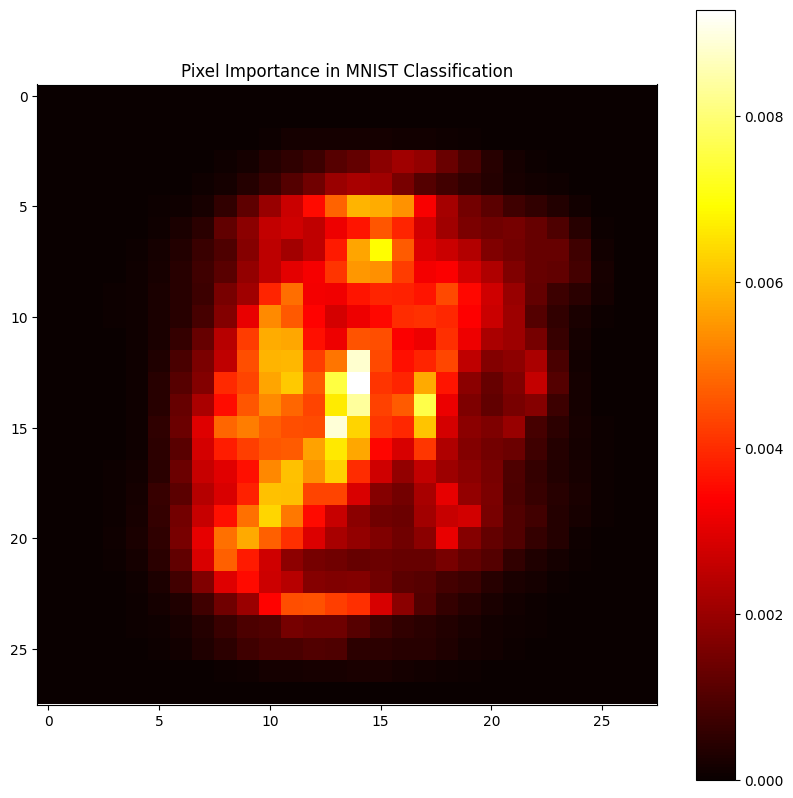

In [58]:
from sklearn.datasets import fetch_openml  # Chargement de la base de données MNIST originale
mnist = fetch_openml('mnist_784', version=1, parser='auto')

X, y = mnist['data'], mnist['target']  # X et y sont des DataFrame et non des tableaux NumPy
X = X.to_numpy()
y = y.to_numpy()
y = y.astype(int)  # Important sinon les éléments de y ne sont pas considérés comme des entiers
X.shape

rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(X, y)

feature_importances = rnd_clf.feature_importances_
feature_importances_image = feature_importances.reshape(28, 28)

plt.figure(figsize=(10, 10))
plt.imshow(feature_importances_image, cmap='hot', interpolation='nearest')
plt.title('Pixel Importance in MNIST Classification')
plt.colorbar()
plt.show()

Boosting

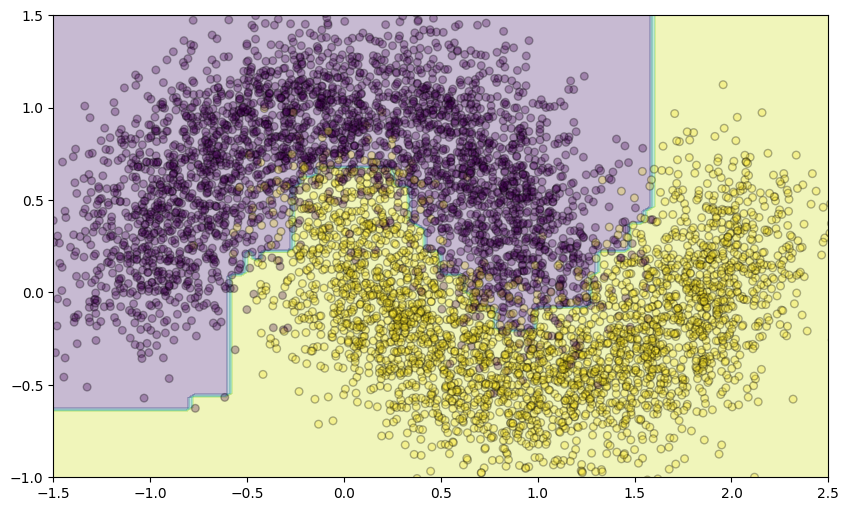

In [59]:
# Adaboost
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=1), n_estimators=200,
        algorithm="SAMME.R", learning_rate=0.5
    )
ada_clf.fit(X_train, y_train)

plt.figure(figsize=(10, 6))
plot_decision_boundary(ada_clf, X_train, y_train, axes=[-1.5, 2.5, -1, 1.5])
plt.show()

In [60]:
from sklearn.metrics import mean_squared_error
y_pred = ada_clf.predict(X_test)
mean_squared_error(y_test, y_pred)

0.06425

In [61]:
# Boosting de gradient
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=2)

In [62]:
y2 = y_train - tree_reg1.predict(X_train)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X_train, y2)

DecisionTreeRegressor(max_depth=2)

In [63]:
y3 = y2 - tree_reg2.predict(X_train)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X_train, y3)

DecisionTreeRegressor(max_depth=2)

In [64]:
y_pred = sum(tree.predict(X_test) for tree in (tree_reg1, tree_reg2, tree_reg3))
mean_squared_error(y_test, y_pred)

0.06505203581698733

In [65]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

In [71]:
# GBRT avec le nombre d'arbres optimal
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = 2 * np.random.rand(100, 1)
y = X**2 - 2 * X + 1 + 0.1 * np.random.randn(100,1)

sorted_indices = np.argsort(X[:, 0])
X = X[sorted_indices]
y = y[sorted_indices]

y = y.ravel()

X_train, X_val, y_train, y_val = train_test_split(X, y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=48)

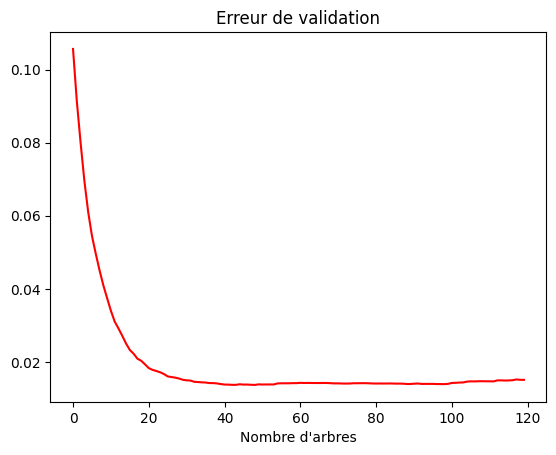

In [72]:
plt.plot(errors, "r-")
plt.xlabel("Nombre d'arbres")
plt.title("Erreur de validation")
plt.show()

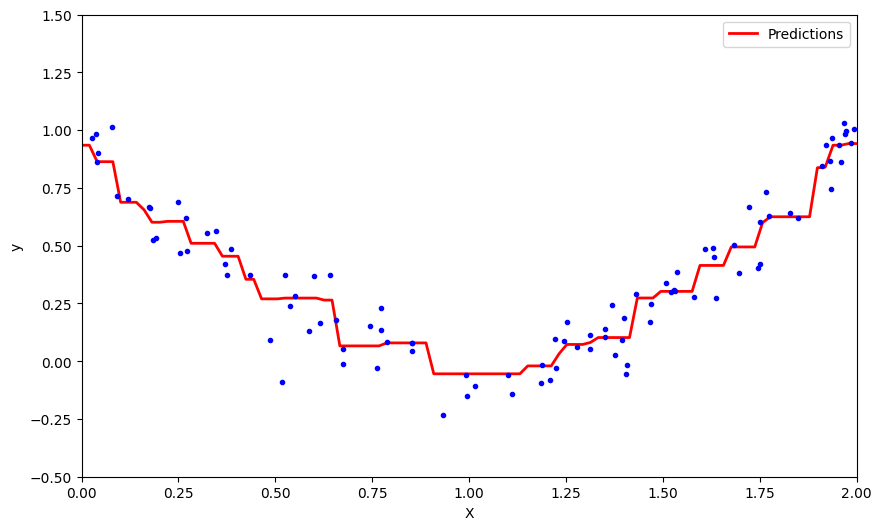

In [73]:
def plot_decision_boundary_reg(reg, X, y, axes):
    X_new = np.linspace(axes[0], axes[1], 100).reshape(-1, 1)
    y_pred = reg.predict(X_new)
    plt.plot(X_new, y_pred, "r-", linewidth=2, label="Predictions")
    plt.plot(X, y, "b.")
    plt.xlabel("X")
    plt.ylabel("y")
    plt.axis(axes)
    plt.legend()

plt.figure(figsize=(10, 6))
plot_decision_boundary_reg(gbrt_best, X, y, axes=[0, 2, -0.5, 1.5])
plt.show()

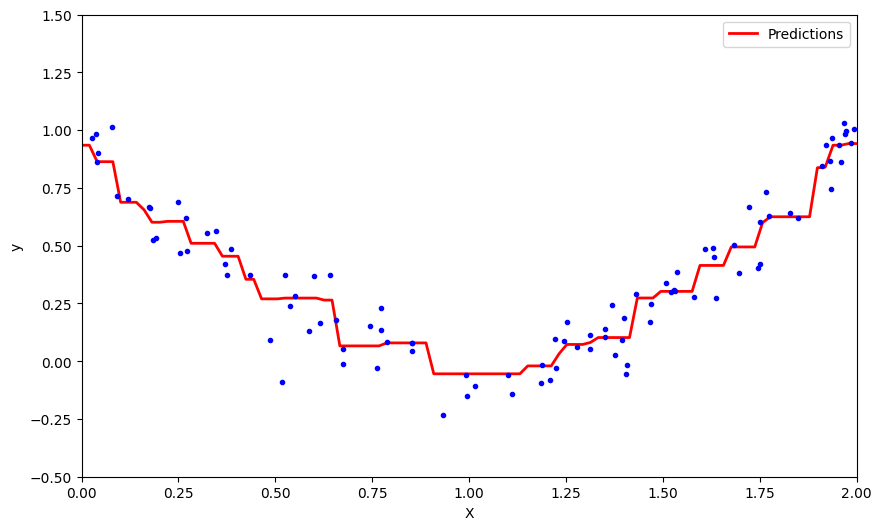

In [77]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float('inf')
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # arrêt précoce

plt.figure(figsize=(10, 6))
plot_decision_boundary_reg(gbrt, X, y, axes=[0, 2, -0.5, 1.5])
plt.show()